# Run two layer model with AR6 forcing

- This will probably be deleted and replaced.

In [1]:
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
import pickle
from multiprocessing import Pool

from ar6.utils.h5 import *
from ar6.forcing.aerosol import aerocom_n, ghan

from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
from fair.constants import molwt
from fair.constants.general import EARTH_RADIUS
from fair.ancil import natural, cmip6_volcanic, cmip6_solar

import openscm_units.unit_registry as ur
from scmdata import ScmRun, run_append

from openscm_twolayermodel import TwoLayerModel
import tqdm.autonotebook as tqdman

from tqdm.notebook import tqdm

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
fair.__version__

'1.6.1'

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [3]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [4]:
SAMPLES = 2000
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)
F2XCO2_MEAN = 4.00
F2XCO2_NINETY = 0.48

In [5]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.097336,348.420476,6.683996,12.730074,15.447054,2.312083,60.599376
1751,2.072491,343.819148,6.615537,12.587160,15.188102,2.281498,59.667759
1752,2.063877,341.701465,6.573965,12.589121,15.033861,2.270899,59.213713
1753,2.071515,343.567551,6.635011,12.534665,15.181930,2.284976,59.610148
1754,2.098914,349.707369,6.767852,12.631676,15.558158,2.336934,60.855827
...,...,...,...,...,...,...,...
2015,7.992567,894.144647,62.462922,138.718989,30.046634,91.076152,213.006570
2016,7.918346,874.700320,63.054904,137.128483,30.086767,87.215738,211.778440
2017,7.886938,867.879243,63.739495,137.159668,30.057079,84.269791,211.717165


## Thermal parameters

0.722492176996794
[2.06109769 2.33849959 2.98521046 3.99830126 5.12703314]
[1.2355143  1.44407451 1.7937823  2.21038029 2.54154444]


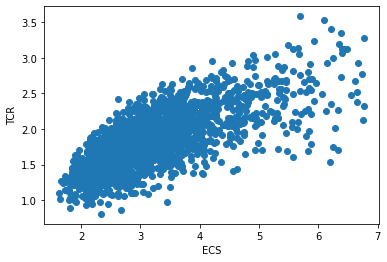

In [6]:
# draw distributions of ECS and TCR: 5-95% range 1.0 to 2.2 for TCR normal, 2-5 for ECS lognormal
seed    = SEEDS[9]

feedback = 4/3 * st.truncnorm.rvs(-2.0, np.inf, loc=1, scale=0.28, size=SAMPLES, random_state=SEEDS[18])
f2x = 4.00
ecs = f2x/feedback
rwf = st.norm.rvs(size=SAMPLES, loc=np.maximum(0.8*np.exp(-0.075*ecs**1.2), 0.2), scale=0.11*np.exp(-0.09*ecs**0.9), random_state=11)
tcr = ecs*rwf
tcrecs = np.stack((tcr,ecs)).T

pl.scatter(ecs, tcr)
pl.xlabel('ECS')
pl.ylabel('TCR')
print(np.corrcoef((ecs,tcr))[0,1])
print(np.percentile(ecs, (5,16,50,84,95)))
print(np.percentile(tcr, (5,17,50,83,95)))

From Gregory & Forster 2008 and Jiminez... & Mauritsen 2019, we have kappa = efficacy * eta

In Smith et al 2020 submitted, the two layer model parameters are, to a good approximation, uncorrelated, so we'll assume independence here too.

(array([ 78., 589., 731., 376., 144.,  57.,  16.,   6.,   0.,   3.]),
 array([0.12386013, 0.43620308, 0.74854602, 1.06088897, 1.37323192,
        1.68557486, 1.99791781, 2.31026075, 2.6226037 , 2.93494665,
        3.24728959]),
 <BarContainer object of 10 artists>)

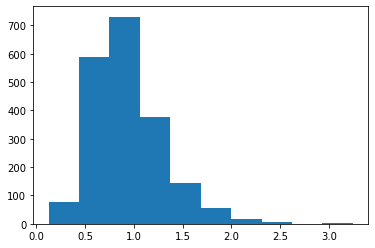

In [7]:
kappa = f2x/tcr - f2x/ecs
# kappa = efficacy * eta
pl.hist(kappa)

In [8]:
f2x = st.norm.rvs(loc=F2XCO2_MEAN, scale=F2XCO2_NINETY/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[72])

with open("../data_output/cmip6_twolayer_tuning_params.json", "r") as read_file:
    cmip6_models = json.load(read_file)
params = pd.DataFrame({
    param:cmip6_models[param]['model_data'] for param in cmip6_models
})
params.drop(columns=['T4xCO2'], inplace=True)
NMODELS = len(cmip6_models)

lambda0 = feedback
efficacy = st.norm.rvs(loc=params.efficacy.mean(), scale=params.efficacy.std(), size=SAMPLES, random_state=SEEDS[65])
eta = kappa/efficacy
dl = st.truncnorm.rvs(-NINETY_TO_ONESIGMA, NINETY_TO_ONESIGMA, loc=params.dl.mean(), scale=params.dl.std(), size=SAMPLES, random_state=SEEDS[66])
du = st.truncnorm.rvs(-NINETY_TO_ONESIGMA, NINETY_TO_ONESIGMA, loc=params.du.mean(), scale=params.du.std(), size=SAMPLES, random_state=SEEDS[67])

(array([ 93., 143., 215., 238., 293., 262., 273., 235., 142., 106.]),
 array([22.27437468, 28.17367767, 34.07298066, 39.97228365, 45.87158664,
        51.77088963, 57.67019262, 63.56949561, 69.4687986 , 75.36810159,
        81.26740459]),
 <BarContainer object of 10 artists>)

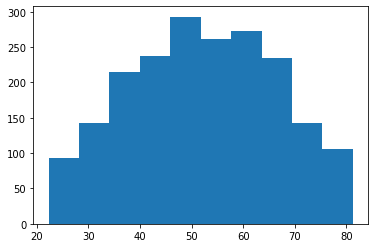

In [9]:
pl.hist(du)

(array([559., 934., 357.,  97.,  30.,  13.,   3.,   4.,   1.,   2.]),
 array([0.11731066, 0.5372712 , 0.95723174, 1.37719228, 1.79715282,
        2.21711335, 2.63707389, 3.05703443, 3.47699497, 3.89695551,
        4.31691605]),
 <BarContainer object of 10 artists>)

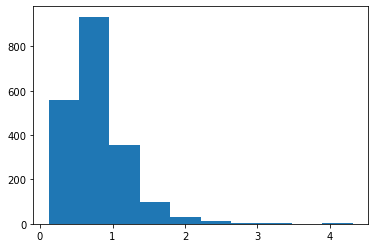

In [10]:
pl.hist(eta)

[2.06109769 2.33849959 2.98521046 3.99830126 5.12703314]


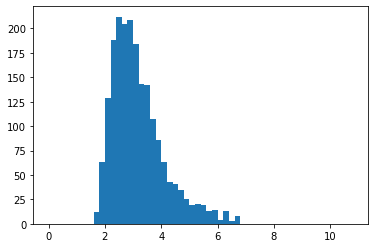

In [11]:
pl.hist(ecs, bins=np.arange(0,11,0.2))
print(np.percentile(ecs, (5,16,50,84,95)))

[1.2355143  1.43284527 1.7937823  2.23126745 2.54154444]


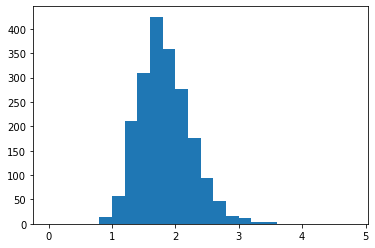

In [12]:
# TCR is alternatively given from two layer model
pl.hist(tcr, bins=np.arange(0,5,0.2))
print(np.percentile(tcr, (5,16,50,84,95)))

In [13]:
print(np.percentile(ecs, (5,16,50,84,95)))
print(np.percentile(tcr, (5,16,50,84,95)))

[2.06109769 2.33849959 2.98521046 3.99830126 5.12703314]
[1.2355143  1.43284527 1.7937823  2.23126745 2.54154444]


## Forcing uncertainties - ensure consistency with 040

In [14]:
seed    = 36572 
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# to do move to module

# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.19,      # other WMGHGs
    0.50,      # Total ozone
    1.00,      # stratospheric WV from CH4
    0.70,      # contrails approx - half-normal
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    0.50,      # solar (amplitude)
])/NINETY_TO_ONESIGMA

scale = st.norm.rvs(size=(SAMPLES,11), loc=np.ones((SAMPLES,11)), scale=np.ones((SAMPLES, 11)) * unc_ranges[None,:], random_state=seed)
#scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
# refine this calc and maybe half normal it

# here's a half normal
## bc snow is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale[scale[:,7]<1,7] = 0.06/0.1*(scale[scale[:,7]<1,7]-1) + 1

## so is contrails - the benefits of doing this are tiny :)
scale[scale[:,6]<1,6] = 0.0384/0.0406*(scale[scale[:,6]<1,6]-1) + 1

trend_solar = st.norm.rvs(size=SAMPLES, loc=+0.01, scale=0.07/NINETY_TO_ONESIGMA, random_state=138294)
#trend_solar[trend_solar>-0.01] = 11/4 * (trend_solar[trend_solar>-0.01]+0.01)-0.01

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)

### Aerosol emissions

ERFari is based on emissions to forcing coefficients from Myhre et al (2013) https://acp.copernicus.org/articles/13/1853/2013/. There is not sufficient evidence from CMIP6 AerChemMIP models or any other sources to update these. The uncertainty ranges from each precursor are expanded slightly compared to Myhre et al., in order to reproduce the overall ERFari uncertainty assessment (assumed that uncertainties in individual components are uncorrelated).

ERFaci is based on fits to CMIP6 models from Smith et al. (2020) https://www.essoar.org/doi/abs/10.1002/essoar.10503977.2

Rescale both to the assessed forcings of -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

In [15]:
df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=786418)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.70/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=31318990)

ERFari = np.zeros((270,SAMPLES))
ERFaci = np.zeros((270,SAMPLES))
    
bc = emissions_ceds_update['BC'].values.squeeze()
oc = emissions_ceds_update['OC'].values.squeeze()
so2 = emissions_ceds_update['SO2'].values.squeeze()
nh3 = emissions_ceds_update['NH3'].values.squeeze()

for i in tqdm(range(SAMPLES), leave=False):
    ts2010 = np.mean(
        ghan(
            [
                so2[255:265],
                    bc[255:265]+
                    oc[255:265],
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
        )
    )
    ts1750 = ghan(
        [
            so2[0],
                bc[0]+
                oc[0],
        ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
    )
    ERFaci[:,i] = (
        ghan([so2, bc+oc], 1.11, aci_coeffs[i,0], aci_coeffs[i,1])
    - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

In [16]:
bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[97])
nh3_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[98])

beta_bc = bc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = oc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = so2_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = nh3_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari = np.zeros((270, SAMPLES))
for i in tqdm(range(SAMPLES)):
    ERFari[:, i] = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2[i] +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc[i] +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc[i] +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3[i]
    )
    
beta_bc = 0.3/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = -0.09/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = -0.4/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = -0.11/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari_median = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2 +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3 
    )
ERFaci_median = np.percentile(ERFaci, 50, axis=1) * (-1.0)/(np.percentile(ERFaci, 50, axis=1)[255:265].mean())

## Non-aerosol forcings

In [17]:
df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
forcing_ensemble = {}
forcing_ensemble['co2'] = df['co2'].values[:,None] * scale_df['co2'].values[None,:]
forcing_ensemble['ch4'] = df['ch4'].values[:,None] * scale_df['ch4'].values[None,:]
forcing_ensemble['n2o'] = df['n2o'].values[:,None] * scale_df['n2o'].values[None,:]
forcing_ensemble['other_wmghg'] = df['other_wmghg'].values[:,None] * scale_df['other_wmghg'].values[None,:]
forcing_ensemble['o3'] = df['o3'].values[:,None] * scale_df['o3'].values[None,:]
forcing_ensemble['h2o_stratospheric'] = df['h2o_stratospheric'].values[:,None] * scale_df['h2o_stratospheric'].values[None,:]
forcing_ensemble['contrails'] = df['contrails'].values[:,None] * scale_df['contrails'].values[None,:]
forcing_ensemble['aerosol-radiation_interactions'] = ERFari
forcing_ensemble['aerosol-cloud_interactions'] = ERFaci
forcing_ensemble['bc_on_snow'] = df['bc_on_snow'].values[:,None] * scale_df['bc_on_snow'].values[None,:]
forcing_ensemble['land_use'] = df['land_use'].values[:,None] * scale_df['land_use'].values[None,:]
forcing_ensemble['volcanic'] = df['volcanic'].values[:,None] * scale_df['volcanic'].values[None,:]
forcing_ensemble['solar'] = df['solar'].values[:,None] * scale_df['solar'].values[None,:]
forcing_ensemble['total'] = (
    forcing_ensemble['co2'] +
    forcing_ensemble['ch4'] +
    forcing_ensemble['n2o'] +
    forcing_ensemble['other_wmghg'] +
    forcing_ensemble['o3'] +
    forcing_ensemble['h2o_stratospheric'] +
    forcing_ensemble['contrails'] +
    forcing_ensemble['aerosol-radiation_interactions'] +
    forcing_ensemble['aerosol-cloud_interactions'] +
    forcing_ensemble['bc_on_snow'] +
    forcing_ensemble['land_use'] +
    forcing_ensemble['volcanic'] +
    forcing_ensemble['solar']
)

In [18]:
forcing_ensemble['total'][:,0].shape

(270,)

# Run climate model

this is too slow - use fair?

In [19]:
arglist = []

dl = np.array(dl)
du = np.array(du)
eta = np.array(eta)
lambda0 = np.array(lambda0)
efficacy = np.array(efficacy)

for i in range(SAMPLES):
    arglist.append(
        {
            'dl': dl[i],
            'du': du[i],
            'eta': eta[i],
            'lambda0': lambda0[i],
            'efficacy': efficacy[i],
            'in_forcing' : forcing_ensemble['total'][:,i],
            'run_id': i
        }
    )

In [20]:
runner = TwoLayerModel()
output = []

def run_tlm(args):
    in_forcing = args['in_forcing']
    driver = ScmRun(
        data=in_forcing,#[:,None]*np.ones((270,500)),
        index=np.arange(1750,2020),
        columns={
            "unit": "W/m^2",
            "model": "openscm-twolayermodel-0.2.0",
            "scenario": "historical-AR6",
            "region": "World",
            "variable": "Effective Radiative Forcing",
            "run_id": args['run_id']
        }
    )
    runner.dl = args['dl']*ur(cmip6_models['dl']['units'])
    runner.du = args['du']*ur(cmip6_models['du']['units'])
    runner.eta = args['eta']*ur(cmip6_models['eta']['units'])
    runner.lambda0 = args['lambda0'] * ur(cmip6_models['lambda0']['units'])
    runner.efficacy = args['efficacy'] * ur(cmip6_models['efficacy']['units'])
    return (runner.run_scenarios(driver, progress=False))
    
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_tlm, arglist), total=SAMPLES))
    output = run_append(result)

In [21]:
results = {}
results['historical-AR6'] = {}
MODEL_TIMESTEP = runner.delta_t.to('s').magnitude
results['historical-AR6']['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
results['historical-AR6']['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T
results['historical-AR6']['deep_ocean_temperature'] = output.filter(variable='Surface Temperature|Lower').timeseries().values.T
results['historical-AR6']['net_energy_imbalance'] = output.filter(variable='Heat Uptake').timeseries().values.T
results['historical-AR6']['ocean_heat_content'] = (
    np.cumsum(results['historical-AR6']['net_energy_imbalance'], axis=0) * 4 * np.pi * EARTH_RADIUS**2 * MODEL_TIMESTEP
)
results['historical-AR6']['ECS'] = ecs
results['historical-AR6']['TCR'] = tcr
results['historical-AR6']['lambda0'] = lambda0
results['historical-AR6']['eta'] = eta
results['historical-AR6']['efficacy'] = efficacy
results['historical-AR6']['dl'] = dl
results['historical-AR6']['du'] = du

save_dict_to_hdf5(results, '../data_input_large/twolayer_historical-AR6.h5')

In [22]:
results['historical-AR6']['ECS']

array([2.46459009, 2.6508863 , 3.37249121, ..., 3.07251582, 3.51517269,
       2.40441861])